**Train DeepCell Model with Nuclear Images and Make Predictions**<br>
It trains a model with three heads: inner distance, outer distance, and fgbg. It works on tensorflow 2.7.1.<br>
Tissuenet V1.0 dataset is used, which has images of size 512x512 in the "Intro to DeepCell" are 256x256. In contrast, the pretrained model in NuclearApplication was trained on images of 512x512. There are 735850 training instances and 180076 validation instances.<br>
Training can also be done via deepcell.training.train_model_sample, which allows arbitrary size images and uses window_size to control patch size.<br>
Best mAP 0.39 at mpp=1

In [1]:
model_name = 'tn1.0_nuclear'
idx_X=0; idx_y=1 # image channel and mask channel
model_path = '{}.h5'.format(model_name)
epochs=60 # to train with tissuenet data. about 6 epochs/hr

In [2]:
import syotil

import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
from timeit import default_timer

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE

import deepcell
from deepcell.utils.train_utils import rate_scheduler, get_callbacks, count_gpus
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell import image_generators

print(tf.__version__)

2.7.1


In [3]:
train_dict = np.load('/fh/fast/fong_y/tissuenet_v1.0/tissuenet_v1.0_train.npz')
train_X, train_y = train_dict['X'], train_dict['y']

# # val is 256x256, thus not used
# val_dict = np.load('/fh/fast/fong_y/tissuenet_v1.0/tissuenet_v1.0_val.npz')
# X_val, y_val = val_dict['X'], val_dict['y']

In [4]:
seed = 0 
n=train_X.shape[0]

min_objects = 2

val_size = 0.2 # fraction of data saved as validation

import random
tmp = random.sample(range(n), int(val_size*n))

X_val = np.expand_dims(train_X[tmp,:,:,idx_X], axis=-1)
y_val = np.expand_dims(train_y[tmp,:,:,idx_y], axis=-1)

tmp1 = list(set(range(n)).difference (set(tmp)))
X_train = np.expand_dims(train_X[tmp1,:,:,idx_X], axis=-1)
y_train = np.expand_dims(train_y[tmp1,:,:,idx_y], axis=-1)

print('X_train.shape: {}\nX_val.shape: {}'.format(
    X_train.shape, X_val.shape))
transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}

# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator()

batch_size = 4 # 8 causes memory outage

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

# get number of training and validation instances

cnts_train = [np.max(y_train[i,...]) for i in range(y_train.shape[0])]
print(np.sum(cnts_train)) # total number of training instances

cnts_val = [np.max(y_val[i,...]) for i in range(y_val.shape[0])]
print(np.sum(cnts_val)) # total number of validation instance

X_train.shape: (2081, 512, 512, 1)
X_val.shape: (520, 512, 512, 1)
731760
184166


/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


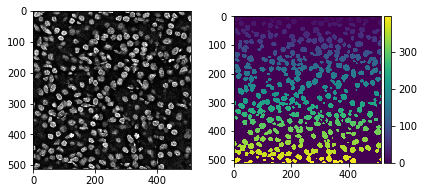

In [5]:
i=5
plt.subplot(1, 2, 1) # row 1, col 2 index 1
io.imshow(X_train[i,:,:,0])
plt.subplot(1, 2, 2) # row 1, col 2 index 1
# tmp = syotil.masks_to_outlines(y_train[i,:,:,0]); io.imshow(tmp)
io.imshow(y_train[i,:,:,0])
plt.show()

**The two cells below define and train the model.** They can be skipped if a trained model will be loaded.

In [114]:
semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Create a dictionary of losses for each semantic head

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)]

2022-10-31 20:11:25.276232: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-31 20:11:36.489304: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-10-31 20:11:36.500164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-10-31 20:11:36.501358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0
/app/software/TensorFlow/2.7.1-foss-2021b

[('semantic_0', (None, 512, 512, 1)),
 ('semantic_1', (None, 512, 512, 1)),
 ('semantic_2', (None, 512, 512, 2))]

In [120]:
# fit the model
print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=epochs, 
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 3 GPUs.


2022-10-31 20:14:49.099508: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-10-31 20:14:49.100694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-10-31 20:14:49.101966: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


Epoch 1/2
520/520 [==============================] - ETA: 0s - loss: 0.0403 - semantic_0_loss: 0.0205 - semantic_1_loss: 0.0180 - semantic_2_loss: 0.0019
Epoch 00001: val_loss improved from inf to 0.13796, saving model to tn1.0_nuclear.h5


/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


520/520 [==============================] - 613s 1s/step - loss: 0.0403 - semantic_0_loss: 0.0205 - semantic_1_loss: 0.0180 - semantic_2_loss: 0.0019 - val_loss: 0.1380 - val_semantic_0_loss: 0.0348 - val_semantic_1_loss: 0.0776 - val_semantic_2_loss: 0.0256 - lr: 1.0000e-04
Epoch 2/2
520/520 [==============================] - ETA: 0s - loss: 0.0133 - semantic_0_loss: 0.0058 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012
Epoch 00002: val_loss improved from 0.13796 to 0.01121, saving model to tn1.0_nuclear.h5
520/520 [==============================] - 601s 1s/step - loss: 0.0133 - semantic_0_loss: 0.0058 - semantic_1_loss: 0.0063 - semantic_2_loss: 0.0012 - val_loss: 0.0112 - val_semantic_0_loss: 0.0051 - val_semantic_1_loss: 0.0052 - val_semantic_2_loss: 9.5388e-04 - lr: 9.9000e-05


<B>Make predictions on Nuclear test dataset.</B> 

In [6]:
prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape= X_val.shape[1:]
)

prediction_model.load_weights(model_path, by_name=True)

2022-11-03 20:47:51.401849: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-11-03 20:47:54.833530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-03 20:47:54.834976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-03 20:47:54.836218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


**Make predictions on validation data. Not enough memory**


In [ ]:
# insufficient memory error!

start = default_timer()
test_images = prediction_model.predict(X_val)
watershed_time = default_timer() - start

# print('Watershed segmentation of shape', test_images[0].shape, 'in', watershed_time, 'seconds.')

masks = deep_watershed(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=0)


In [ ]:
io.imshow(X_val[1,:,:,0])
plt.show()
io.imshow(y_val[1,:,:,0])
plt.show()
print(X_val.shape)
print(y_val.shape)

APs = [syotil.csi(y_val[i,:,:,0], masks[i,:,:,0]) for i in range(y_val.shape[0])]
print(np.nanmean(APs))

**Make prediction on K's data.**<br>
Using NuclearSegmentation allows setting image_mpp, which has a substantial influence on performance.

In [8]:
from deepcell.applications import NuclearSegmentation
app = NuclearSegmentation(prediction_model)
[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), app.model.layers)]

[('semantic_0', (None, 512, 512, 1)), ('semantic_1', (None, 512, 512, 1))]

In [9]:
import os
print(os.getcwd())
INPUT_PATH="images/test/"
FILENAMES = [f for f in os.listdir("images/training/testimages")]
print(FILENAMES)

/home/yfong/deeplearning/dense_cell_segmentation
['M926910_CFL_Position7_CD3_test_img.png', 'M872956_JML_Position10_CD3_test_img.png', 'M872956_JML_Position8_CD8_test_img.png', 'M926910_CFL_Position13_CD3_test_img.png', 'M872956_JML_Position8_CD3_test_img.png', 'M872956_JML_Position8_CD4_test_img.png', 'M872956_JML_Position9_CD3_test_img.png']


In [10]:
# more detailed mapping of image_mpp parameter
mpps = np.linspace(start=0.7, stop=1.6, num=10)
AP_mat=[]
for CURR_IM_NAME in FILENAMES:
    print(CURR_IM_NAME)
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    AP_arr=[]
    for mpp in mpps:
        prd = app._untile_output(app.predict(y, image_mpp=mpp), tile_info)[0,:,:,0]
        a=syotil.csi(mask_true, prd)
        AP_arr.append(a)
    AP_mat.append(AP_arr)

#AP_mat

print(mpps)
[x.index(np.max(x)) for x in AP_mat]

M926910_CFL_Position7_CD3_test_img.png


2022-11-03 20:49:34.360781: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202
/app/software/DeepCell/0.11.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0.Please use `footprint` instead.
  markers = h_maxima(image=maxima,


M872956_JML_Position10_CD3_test_img.png
M872956_JML_Position8_CD8_test_img.png
M926910_CFL_Position13_CD3_test_img.png
M872956_JML_Position8_CD3_test_img.png
M872956_JML_Position8_CD4_test_img.png
M872956_JML_Position9_CD3_test_img.png
[0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6]


[5, 4, 1, 6, 3, 1, 5]

In [13]:
mpp_select=1 # close to the best, it is what is used in resizing later

APs={}
for CURR_IM_NAME in FILENAMES:
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    print(x.shape)
    print(y.shape)
    print(tile_info)
    pred = app.predict(y, image_mpp=mpp_select)
    prd = app._untile_output(pred, tile_info)
    #io.imshow(prd[0,:,:,0])
    plt.show()
    
    APs[CURR_IM_NAME] = syotil.csi(mask_true, prd[0,:,:,0])# masks may lose one pixel if dimension is odd pixels

APs["mAP"]=np.mean(list(APs.values()))
print(APs)

(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}


/app/software/DeepCell/0.11.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0.Please use `footprint` instead.
  markers = h_maxima(image=maxima,


(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
{'M926910_CFL_Position7_CD3_test_img.png': 0.37422360248447206, 'M872956_JML_Position10_CD3_test_img.png': 0.4336283185840708, 'M872956_JML_Position8_CD8_test_img.png': 0.38493723849372385, 'M926910_CFL_Position13_CD3_test_img.png': 0.2435344827586207, 'M872956_JML_Position8_CD3_test_img.png': 0.4666666666666667, 'M872956_JML_Position8_CD4_test_img.png': 0.43209876543209874, 'M872956_JML_Position9_CD3_test_img.png': 0.37

In [14]:
import pandas as pd
df = pd.DataFrame([FILENAMES+["mAP"], list(APs.values())])
print(df.transpose())
df.to_csv('images/training/csi_'+model_name+'.txt', index=False, header=False)

                                         0         1
0   M926910_CFL_Position7_CD3_test_img.png  0.374224
1  M872956_JML_Position10_CD3_test_img.png  0.433628
2   M872956_JML_Position8_CD8_test_img.png  0.384937
3  M926910_CFL_Position13_CD3_test_img.png  0.243534
4   M872956_JML_Position8_CD3_test_img.png  0.466667
5   M872956_JML_Position8_CD4_test_img.png  0.432099
6   M872956_JML_Position9_CD3_test_img.png  0.373308
7                                      mAP  0.386914


**mAP**<br>
image_mpp=1: 0.39<br>
image_mpp=1.3: 0.36<br>
<br>
<br>
**AP for M872956_JML_Position8_CD3_test_img**<br>
image_mpp default: 0.27 <br>
image_mpp=1: .46<br>
image_mpp=2: .16<br>
For comparison, when model is trained with demo nuclear data, best performance is <br>
image_mpp=2: .3<br>
And with the pretrained DeepCell nuclear segmentation model, best performance is <br>
image_mpp=1: 0.37<br>